# Data initial exploration - Torch Version
*Matthieu OLEKHNOVITCH*

## Introduction 
This notebook is dedicated to the initial exploration of the data. It is the first step of the data science process. The goal is to get a first idea of the data, to understand it and to identify the main challenges.

In [39]:
import numpy as np
import pandas as pd
import networkx as nx
import json
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import os

In [42]:
# ----------------- Load Training Labels -----------------#

training_label_path = 'training_labels.json'
print(os.path.dirname(os.path.abspath(training_label_path)))
try :
    labels_data = json.load(open(training_label_path))
    print(training_label_path + ' loaded')

except FileNotFoundError:
    print('File not found: ', training_label_path)


# ----------------- Load Training Data -------------------#

training_data_path = 'training/'
discussion_ids = []
for key in labels_data.keys():
    discussion_ids.append(key)

print('Number of discussions: ', len(discussion_ids))



# -------------------------------------------------------#

c:\Users\Olek\Documents\GitHub\Kaggle-competition---Extractive-Summarization-with-Discourse-Graphs
training_labels.json loaded
Number of discussions:  97


# Building a conversation graph (torch version)

Discussion ID:  IS1003d
Discussion file loaded
Number of posts:  1095
Numbers of true labels:  tensor(132)
Number of labels 1095
Starting nodes:  [   0    1    1 ... 1091 1092 1091]
Number of edges:  1094
[3, 14, 4, 10, 6, 4, 10, 0, 4, 4, 4, 9, 4, 9, 14, 3, 14, 14, 15, 0, 9, 0, 6, 6, 6, 0, 0, 0, 4, 0, 6, 4, 6, 4, 6, 7, 4, 9, 7, 0, 4, 4, 10, 0, 4, 6, 4, 3, 14, 14, 6, 6, 9, 4, 0, 7, 6, 0, 4, 9, 6, 9, 4, 0, 9, 10, 0, 4, 4, 7, 6, 0, 0, 7, 0, 15, 9, 6, 0, 0, 0, 0, 0, 0, 9, 9, 7, 15, 0, 0, 7, 0, 0, 9, 9, 15, 10, 15, 6, 9, 0, 0, 0, 15, 0, 0, 0, 7, 0, 0, 0, 9, 0, 9, 10, 9, 6, 0, 0, 0, 7, 3, 4, 7, 4, 15, 4, 14, 4, 0, 3, 0, 14, 15, 0, 0, 10, 7, 0, 7, 0, 6, 9, 14, 10, 6, 6, 0, 0, 4, 0, 6, 7, 5, 9, 0, 9, 5, 15, 5, 6, 9, 6, 0, 11, 14, 6, 14, 0, 6, 3, 13, 7, 3, 6, 0, 3, 14, 14, 15, 7, 15, 7, 15, 14, 9, 7, 9, 11, 6, 0, 0, 6, 15, 15, 4, 6, 0, 4, 4, 6, 0, 3, 14, 14, 9, 7, 9, 14, 6, 0, 7, 3, 7, 14, 7, 14, 0, 6, 7, 6, 0, 6, 7, 6, 14, 14, 0, 9, 0, 4, 4, 9, 4, 7, 3, 0, 6, 6, 14, 14, 14, 9, 5, 4, 4, 4, 3, 1

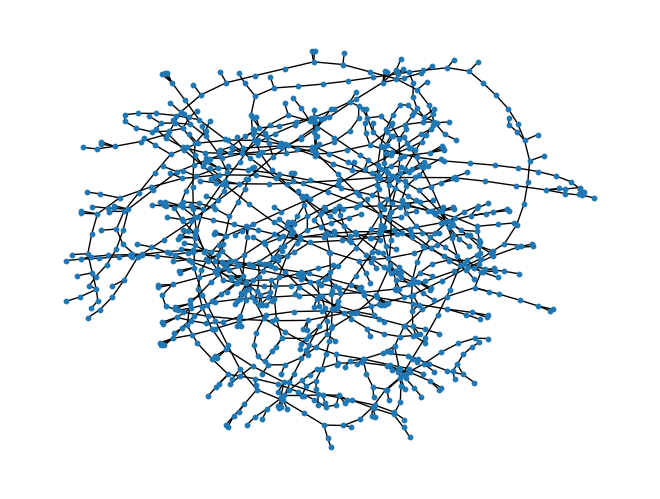

In [77]:
# ------------------ Loading Discussions ----------------#  

discussion_id = discussion_ids[0]                                  # Select a discussion

print('Discussion ID: ', discussion_id)
discussion_path = training_data_path + discussion_id + '.json'
try :
    discussion_json = json.load(open(discussion_path))
    print('Discussion file loaded')
except: 
    print('Error loading discussion file')

num_of_posts = len(discussion_json)
print('Number of posts: ', num_of_posts)

discussion_labels = torch.tensor(labels_data[discussion_id], dtype=int)
# Convert i to True false
discussion_labels = discussion_labels ==1
print('Numbers of true labels: ', discussion_labels.sum())
print('Number of labels', discussion_labels.shape[0])

# ----------------------Loading edges----------------------#

edges_path = training_data_path + discussion_id + '.txt'
edges = np.array(np.loadtxt(edges_path, dtype=str))
starting_nodes = (edges[:, 0]).astype(int)
ending_nodes = edges[:, 2].astype(int)
print('Starting nodes: ', starting_nodes)
print('Number of edges: ', len(edges))

# Convert egdes[:,1] using label_dict.json
label_dict = json.load(open('label_dict.json'))
edge_labels = []
for i in range(len(edges)):
    edge_labels.append(label_dict[edges[i, 1]])
print(edge_labels)
edge_labels = torch.tensor(edge_labels, dtype=torch.long)

# ----------------- Buidling torch graph ------------------#

nodes = torch.tensor([i for i in range(num_of_posts)], dtype=torch.long)
edge_index_directed = torch.tensor([starting_nodes, ending_nodes], dtype=torch.long)

# ----------------- Visualizing graph ---------------------#

data = Data(x=nodes, edge_index=edge_index_directed, y = discussion_labels, edge_attr=edge_labels)
print(data)
#convert directed graph to net
g = to_networkx(data, to_undirected=True)
#directed graph
nx.draw(g, node_size=10)

## Coding the model (Graph Attention Network)

In [85]:
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GATConv
import torch.nn.functional as F


# Define the GCN model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.gc1 = nn.GraphConvolution(input_dim, hidden_dim)
        self.gc2 = nn.GraphConvolution(hidden_dim, output_dim)

    def forward(self, x, adjacency_matrix):
        x = F.relu(self.gc1(x, adjacency_matrix))
        x = self.gc2(x, adjacency_matrix)
        return F.sigmoid(x)

# Instantiate the model
model = GCN(input_dim=1, hidden_dim=16, output_dim=1)

# Define the loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    output = model(x, adjacency_matrix)
    loss = criterion(output[train_idx], y[train_idx])
    loss.backward()
    optimizer.step()

AttributeError: module 'torch.nn' has no attribute 'GraphConvolution'